# Trabalho de IA: MLP

Integrantes:
- Ana Clara das Neves Barreto - 13672540
- Eloisa Antero Guisse - 13781924
- Marcos Martins de Oliveira Pacheco - 13672602
- Jamyle Gonçalves Rodrigues Silva -
- Lucca Pinto -
- Sarah Klock Mauricio - 13673131

Divas pop q nao tem hit solo ha 50 anos:
- Lady Gaga
- Katy Perry
- Demi Lovato
- Selena Gomez
- Jessie J

## Desenvolvimento do modelo

Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from graphviz import Digraph
import json

Funções que lidam com a conversão entre letras e vetores de binários

In [2]:
alfabeto = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

def letra_para_vetor(letra):
    """
    Transforma um caractere num vetor de 26 posições, no qual a posição da letra correspondente é 1 e o restante é -1.
    :param letra: Letra a ser transformada num vetor
    :return: Vetor binário de 26 posições
    """
    vetor = [-1] * 26
    pos_letra = alfabeto.index(letra)
    vetor[pos_letra] = 1

    return vetor

def vetor_para_letra(vetor):
    """
    Encontra a letra do alfabeto correspondente a um vetor de 26 posições.
    :param vetor: Vetor de 26 posições que representa uma letra do alfabeto.
    :return: Letra correspondente.
    """
    # Encontra a posição do maior valor no vetor
    maior_pos = np.argmax(vetor)

    # Encontra a letra correspondente no alfabeto
    letra = alfabeto[maior_pos]

    return letra

Funções para leituras de arquivos

In [3]:
def ler_arq_imagens(nome_arq):
    """
    Lê o arquivo de imagens e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de imagens.

    Returns:
        np.ndarray: Array numpy contendo as imagens.
    """
    with open(nome_arq, 'r') as file:
        data = file.read().strip().split('\n')
    data = [list(map(int, filter(lambda x: x.strip(), line.split(',')))) for line in data if line.strip()]
    return np.array(data)

def ler_arq_classes(nome_arq):
    """
    Lê o arquivo de classes e retorna um array numpy.

    Args:
        nome_arq (str): Caminho para o arquivo de classes.

    Returns:
        np.ndarray: Array numpy contendo as classes.
    """
    with open(nome_arq, 'r') as file:
        data = []
        for line in file:
            vetor_letra = letra_para_vetor(line[0])
            data.append(vetor_letra)
    return np.array(data)

Funções para a divisão dos dados

In [4]:
def shuffle_dados(dados, classes):
    """
        Embaralha os dados de um vetor mantendo as respectivas classificações na mesma ordem.

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.

        Returns:
            (np.array): Vetor de dados embaralhado.
            (np.array): Vetor de classificação dos dados da primeira parte da divisão.
        """
    indices = np.arange(dados.shape[0])
    np.random.shuffle(indices)
    return dados[indices], classes[indices]

def dividir_dados(entrada, classes, test_proportion=0.2):
    """
        Divide dois vetores de dados em uma determinada proporção (padrão: 80/20).

        Args:
            entrada (np.array): Vetor dos dados a serem divididos.
            classes (np.array): Classificação dos dados a serem dividos.
            div_proportion (float): Proporção da divisão dos dados (padrão: 20%)

        Returns:
            dados_primeira_parte (np.array): Vetor de dados da primeira parte da divisão.
            classes_primeira_parte (np.array): Vetor de classificação dos dados da primeira parte da divisão.
            dados_segunda_parte (np.array): Vetor de dados da segunda parte da divisão.
            classes_segunda_parte (np.array): Vetor de classificação dos dados da segunda parte da divisão.
        """
    # Transforma os vetores das classes nas letras correspondentes
    classes_letras = []
    for elemento in classes:
        classes_letras.append(vetor_para_letra(elemento))

    classes_letras = np.array(classes_letras)

    # Conta o número de classes
    unique_classes, class_counts = np.unique(classes_letras, return_counts=True)
    
    # Calcula a quantidade desejada de cada classe no primeiro conjunto
    desired_counts = (class_counts * (1 - test_proportion)).astype(int)
    
    # Inicializa os vetores para as duas partes
    dados_primeira_parte = []
    classes_primeira_parte = []
    dados_segunda_parte = []
    classes_segunda_parte = []
    
    for classe, desired_count in zip(unique_classes, desired_counts):
        # Índices das amostras da classe atual
        indices_classe = np.where(classes_letras == classe)[0]

        # Seleciona aleatoriamente as amostras para o primeiro conjunto
        selected_indices = np.random.choice(indices_classe, size=desired_count, replace=False)
        
        # Divide os dados e classes
        dados_primeira_parte.append(entrada[selected_indices])
        classes_primeira_parte.append(classes[selected_indices])
        
        # As amostras restantes vão para o segundo conjunto
        remaining_indices = np.setdiff1d(indices_classe, selected_indices)
        dados_segunda_parte.append(entrada[remaining_indices])
        classes_segunda_parte.append(classes[remaining_indices])
    
    # Concatena os vetores
    dados_primeira_parte = np.concatenate(dados_primeira_parte)
    classes_primeira_parte = np.concatenate(classes_primeira_parte)
    dados_segunda_parte = np.concatenate(dados_segunda_parte)
    classes_segunda_parte = np.concatenate(classes_segunda_parte)

    dados_primeira_parte, classes_primeira_parte = shuffle_dados(dados_primeira_parte, classes_primeira_parte)
    dados_segunda_parte, classes_segunda_parte = shuffle_dados(dados_segunda_parte, classes_segunda_parte)

    return dados_primeira_parte, classes_primeira_parte, dados_segunda_parte, classes_segunda_parte


Funcao pra reconstruir imagens a partir do array de array


In [5]:
def reconstruct_image(row_index, image_array):
    """
    Reconstrói e plota uma imagem a partir do array numpy.

    Args:
        row_index (int): Índice da linha da imagem a ser reconstruída.
        image_array (np.ndarray): Array numpy contendo as imagens.
    """
    image_array = image_array[row_index]
    image_reshaped = np.reshape(image_array, (10, 12))

    plt.figure(figsize=(4, 3))
    plt.imshow(image_reshaped, cmap='gray')
    plt.colorbar()
    plt.show()

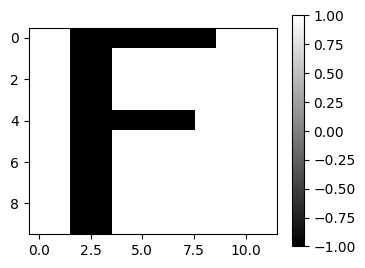

In [6]:
image = ler_arq_imagens('X.txt')
reconstruct_image(5,image)

Função para matriz de confusão

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotar_matriz_de_confusao(predictions, y_test):
    """
    Traduz os dados dos arrays predictions e y_test para outros dois arrays
    apenas contendo as letras previstas e originais de teste e plota uma matriz
    de confusão usando o sklearn.metrics

    Args:
        predictions: Array contendo os resultados previstos pelo MLP.
        y_test: Array contendo os dados de teste do MLP
    """
    
    # Listas que irão conter as letras previstas e de teste
    predictions_letras = []
    y_test_letras = []

    # Converter os arrays de predictions e y_test para letras
    i = 0
    for i in range(len(predictions)):
        letra = vetor_para_letra(predictions[i])
        predictions_letras.append(letra)
    
    j = 0
    for j in range(len(predictions)):    
       letra = vetor_para_letra(y_test[j])
       y_test_letras.append(letra)

    # Array com todas as possibilidades, ou seja, o alfabeto de 'A' a 'Z'
    classes = [chr(i) for i in range(65, 91)] 
        
    cm = confusion_matrix(y_test_letras, predictions_letras, labels= classes)

    # Plot usando ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix using ConfusionMatrixDisplay')
    plt.show()

Funções de ativação

In [8]:
def sigmoid(x, der=False):
    if der:
        fx = sigmoid(x)
        return fx * (1 - fx)
    return 1.0 / (1.0 + np.exp(-x))

def tanh(x, der=False):
    if der:
        return 1 - np.tanh(x) ** 2
    return np.tanh(x)

def relu(x, der=False):
    if der:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def leaky_relu(x, der=False):
    alpha = 0.01
    if der:
        return np.where(x > 0, 1, alpha)
    return np.where(x > 0, x, alpha * x)

def soft_max(x, der=False):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

def activation_function(x, func, der=False):
    return func(x, der)

Função para inicialização de pesos

In [9]:
def init_xavier(n_in, n_out):
    """
    Inicializa os pesos com a inicialização Xavier.

    Args:
        n_in (int): Número de unidades na camada de entrada (ou unidades na camada anterior).
        n_out (int): Número de unidades na camada de saída.

    Returns:
        (numpy.ndarray): Uma matriz de pesos inicializados.
    """
    stddev = np.sqrt(2.0 / (n_in + n_out))
    return np.random.randn(n_in, n_out) * stddev

Classes da MLP (e início efetivo da codificação da rede neural)

In [10]:
class Layer:
    def __init__(self, input_size, output_size, learning_rate, act_fun, output_layer=False):
        """
        Inicializa uma nova camada na rede neural.

        Args:
            input_size (int): Número de neurônios na camada anterior ou tamanho dos dados de entrada.
            output_size (int): Número de neurônios na camada atual.
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.
            act_fun (function): Função de ativação da camada.
            output_layer (bool): Booleano que indica se a camada é a de saída da MLP ou não.

        Attributes:
            weights (np.array): Matriz de pesos, onde cada peso conecta um neurônio de entrada a um neurônio de saída.
            biases (np.array): Vetor de biases, um para cada neurônio de saída.
            weighted_input (np.array): Armazena a entrada ponderada (antes da aplicação de qualquer função de ativação).
            output_data (np.array): Armazena a saída da camada, que neste caso é simplesmente a entrada ponderada.
            input_data (np.array): Armazena a entrada da camada antes da ponderação.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.act_fun = act_fun
        self.output_layer = output_layer
        self.weights = init_xavier(input_size, output_size) 
        self.biases = np.random.randn(1, output_size) 
        self.weighted_input = None
        self.output_data = None
        self.input_data = None

    def forward(self, input_data):
        """
        Realiza o feed forward da camada.

        :param input_data: Vetor de dados de entrada.
        :return: Saída após multiplicação pelos pesos e função de ativação.
        """
        self.input_data = input_data
        self.weighted_input = np.dot(input_data, self.weights) + self.biases
        self.output_data = activation_function(self.weighted_input, self.act_fun)

        return self.output_data

    def backward(self, error):
        """
        Realiza o backward propagation da camada.

        :param error: Erros que serão usados para calcular a correção dos pesos.
        :return: Gradientes para serem usados na correção da camada abaixo.
        """
        # Caso não seja a camada de saída, multiplica o erro pela derivada da função de ativação sobre a entrada ponderada da camada.
        if not self.output_layer:
            error = error * activation_function(self.weighted_input, self.act_fun, True)

        if self.input_data.ndim == 1:
            self.input_data = self.input_data.reshape(1, -1)  # Garante que input_data é bidimensional
        if error.ndim == 1:
            error = error.reshape(1, -1)  # Garante que error é bidimensional

        # Calcula correções e gradientes
        input_error = np.dot(error, self.weights.T)
        weights_error = np.dot(self.input_data.T, error) 

        # Atualiza pesos e biases
        self.weights += self.learning_rate * weights_error
        self.biases += self.learning_rate * np.sum(error, axis=0, keepdims=True)
        return input_error

In [11]:
class NeuralNetwork:
    def __init__(self, learning_rate):
        """
        Inicializa a rede neural com camadas especificadas.

        Args:
            learning_rate (float): Taxa de aprendizado usada para ajustar os pesos e biases durante o treinamento.

        Attributes:
            learning_rate (float): Taxa de aprendizado da rede neural.
            hidden_layer1 (Layer): Primeira camada oculta da rede neural.
            output_layer (Layer): Camada de saída da rede neural.
            final_output (np.array): Armazena a saída final da rede após a propagação direta.
        """
        self.learning_rate = learning_rate
        self.hidden_layer1 = Layer(120, 120, self.learning_rate, sigmoid)
        self.output_layer = Layer(120, 26, self.learning_rate, leaky_relu, True)
        self.final_output = None

    def forward_propagation(self, input_data):
        """
        Realiza a propagação para frente através de toda a rede.

        Args:
            input_data (np.array): Dados de entrada para a rede.

        Returns:
            np.array: Saída final da rede.
        """
        output = self.hidden_layer1.forward(input_data)
        self.final_output = self.output_layer.forward(output)
        return self.final_output

    def back_propagation(self, output_error):
        """
        Realiza a propagação para trás através de toda a rede.

        Args:
            output_error (np.array): Erro na saída da rede.
        """
        error = self.output_layer.backward(output_error)
        self.hidden_layer1.backward(error)

In [17]:
class MultilayerPerceptron:
    def __init__(self, min_output_error=0, max_epochs_num=0, early_stop_param=0, learning_rate=0):
        """
        Inicializa os parâmetros para o treinamento da rede neural.

        Args:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.
            learning_rate (float): Taxa de aprendizado do modelo.

        Attributes:
            min_output_error (float): Erro mínimo desejado para o treinamento.
            max_epochs_num (int): Número máximo de épocas para o treinamento.
            early_stop_param (int): Número de épocas consecutivas com aumento do erro permitido antes da parada antecipada.
            negative_error_var_num (int): Contador de épocas com aumento do erro.
            current_epoch_error (float): Taxa de erro da época atual.
            last_epoch_error (float): Taxa de erro da última época.
            neural_network (NeuralNetwork): Rede neural do modelo.
        """
        self.min_output_error = min_output_error
        self.max_epochs_num = max_epochs_num
        self.early_stop_param = early_stop_param
        self.learning_rate = learning_rate
        self.negative_error_var_num = 0
        self.current_epoch_error = 0
        self.last_epoch_error = 0
        self.neural_network = None

        # Lista para armazenar os erros de treinamento em cada época
        self.training_errors = []

        # Inicializa a rede neural
        neural_network = NeuralNetwork(learning_rate=0.01)
        self.neural_network = neural_network

    def train(self, entrada, classes, earlystop=False):
        """
        Treina a rede neural usando o conjunto de dados de treinamento.

        Args:
            entrada (np.array): Dados de entrada para treinamento.
            classes (np.array): Labels correspondentes para o treinamento.
            earlystop (boolean): Booleano que indica se earlystop será usado ou não
        """
        # Divide os dados de entrada num conjunto de treinamento e outro de validação
        x_train, y_train, x_val, y_val = dividir_dados(entrada, classes)
        
        # Treina a MLP
        for epoch in range(self.max_epochs_num):
            epoch_error = 0

            # Loop que treina a MLP com os dados de treinamento
            for x, y in zip(x_train, y_train):
                output = self.neural_network.forward_propagation(x)
                output_error = y - output
                self.neural_network.back_propagation(output_error)
                epoch_error += np.mean((np.power(output_error, 2))/2)

            train_error = epoch_error / x_train.shape[0]

            # Calcula a acurácia e erro de validação do modelo
            acuracia, val_error = self.get_accuracy(x_val, y_val)

            self.training_errors.append(val_error)

            # Printa erro e acurácia a cada dez épocas
            if epoch % 10 == 0:
                print(
                    f"Época {epoch}/{self.max_epochs_num}, Acurácia: {acuracia}, Erro de validação: {val_error}, Erro de treino: {train_error}")
            
            # Verifica parâmetros de earlystop, caso esteja sendo usada
            if earlystop:
                if train_error < self.min_output_error:
                    print("Erro mínimo atingido. Parando o treinamento.")
                    break
                
                # Verifica se o erro aumentou
                if epoch > 0 and self.training_errors[epoch] > self.training_errors[epoch - 1]:
                    self.negative_error_var_num += 1
                else:
                    self.negative_error_var_num = 0

                if self.negative_error_var_num >= self.early_stop_param:
                    print("Parando antecipadamente devido ao aumento contínuo do erro.")
                    break
            
    def get_accuracy(self, entrada, saida_esperada):
        """
        Obtém a acurácia da MLP.

        Args:
            entrada (np.array): Dados de entrada para teste.
            saida_esperada (np.array): Saída esperada da rede neural.

        Returns:
            acuracia (float): Porcentagem de acertos da rede.
        """

        # Inicializa variáveis para calcular acurácia
        num_testes = 0
        num_acertos = 0
        erro = 0

        # Realiza teste para cada um dos dados de entrada
        for x, y in zip(entrada, saida_esperada):
            num_testes += 1
            
            # Realiza a predição
            predicao = self.neural_network.forward_propagation(x)

            # Calcula erro
            output_error = y - predicao
            erro += np.mean((np.power(output_error, 2) / 2))

            # Obtém a letra predita pelo modelo
            letra_predita = vetor_para_letra(predicao)

            # Obtém a letra esperada
            letra_real = vetor_para_letra(y)

            if letra_predita == letra_real:
                num_acertos += 1

        
        acuracia = num_acertos / num_testes
        erro_medio = erro / entrada.shape[0]

        return acuracia, erro_medio

    def predict(self, entrada):
        """
        Realiza predições usando a rede neural treinada.

        Args:
            entrada (np.array): Dados de entrada para teste.
            neural_network (NeuralNetwork): Instância da rede neural treinada.

        Returns:
            np.array: Predições da rede neural.
        """
        predictions = []
        for x in entrada:
            output = self.neural_network.forward_propagation(x)
            predictions.append(output)
        return np.array(predictions)
    
    def save_mlp(self, nome_arq):
        """
        Armazena os pesos das camadas e os erros médios de cada época num arquivo.

        Args:
            nome_arq (string): Nome do arquivo que irá armazenar os valores.
        """ 

        network = { 
            # Conversão dos pesos da primeira camada oculta para uma lista
            'hidden_layer1': {'weights': self.neural_network.hidden_layer1.weights.tolist(),
                            'biases': self.neural_network.hidden_layer1.biases.tolist()},

            # Conversão dos pesos da camada de saída para uma lista
            'output_layer': {'weights': self.neural_network.output_layer.weights.tolist(),
                            'biases': self.neural_network.output_layer.biases.tolist()},
            
            # Conversão dos erros de cada época para uma lista
            'errors' : self.training_errors
        }

        # Abertura do arquivo para escrita
        with open(nome_arq, 'w') as f:
            # Salvando o dicionário no formato JSON
            json.dump(network, f) 

    def build_mlp(self, nome_arq):
        """
        Constrói a MLP a partir de um arquivo de pesos.

        Args:
            nome_arq (string): Nome do arquivo com os pesos e biases de cada camada.
        """
        with open(nome_arq, 'r') as f:
            network = json.load(f)

        self.neural_network.hidden_layer1.weights = np.array(network['hidden_layer1']['weights'])
        self.neural_network.hidden_layer1.biases = np.array(network['hidden_layer1']['biases'])
        self.neural_network.output_layer.weights = np.array(network['output_layer']['weights'])
        self.neural_network.output_layer.biases = np.array(network['output_layer']['biases'])

        self.training_errors = network['errors']


Main: treina o modelo, printa a execução de cada época e depois obtém a acurácia e erro médio final.

Época 0/1000, Acurácia: 0.038461538461538464, Erro de validação: 0.07429359562323695, Erro de treino: 0.10002802684894355
Época 10/1000, Acurácia: 0.2606837606837607, Erro de validação: 0.0698342631349135, Erro de treino: 0.07008091225790346
Época 20/1000, Acurácia: 0.6196581196581197, Erro de validação: 0.06453091803919649, Erro de treino: 0.06436086841661905
Época 30/1000, Acurácia: 0.8076923076923077, Erro de validação: 0.0587274510373152, Erro de treino: 0.05777752986618691
Época 40/1000, Acurácia: 0.8632478632478633, Erro de validação: 0.053198030849844515, Erro de treino: 0.05102243858330222
Época 50/1000, Acurácia: 0.8675213675213675, Erro de validação: 0.04920762087426955, Erro de treino: 0.045214033131564926
Época 60/1000, Acurácia: 0.8760683760683761, Erro de validação: 0.046290747336163555, Erro de treino: 0.040408105259769365
Época 70/1000, Acurácia: 0.8803418803418803, Erro de validação: 0.04407431801597186, Erro de treino: 0.036205974958491365
Época 80/1000, Acurácia: 0.8

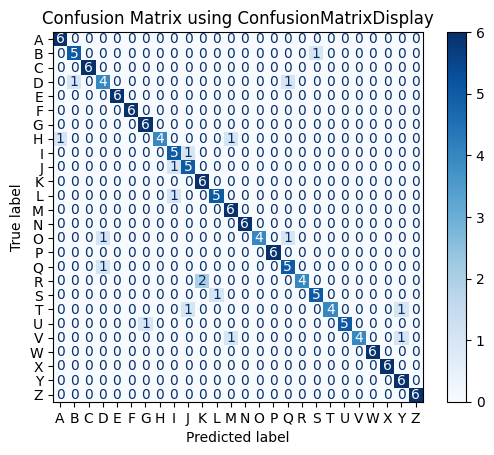

In [22]:
def main():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.1)

    # Convertendo para float
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    # Parâmetros para o treinamento
    min_output_error = 0.015
    max_epochs_num = 1000
    early_stop_param = 7
    learning_rate = 0.1

    # Inicializa o Multilayer Perceptron com os parâmetros de treinamento
    mlp = MultilayerPerceptron(min_output_error, max_epochs_num, early_stop_param, learning_rate)

    # Treina a rede neural
    mlp.train(x_train, y_train, earlystop=True)

    print("Treinamento concluído.")

    acuracia, erro = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")

    # Testa a rede neural
    predictions = mlp.predict(x_test)
    
    # Exibe algumas predições para verificação
    for i in range(20):

        predicao = vetor_para_letra(predictions[i])
        correto = vetor_para_letra(y_test[i])

        print(f"Predição: {predicao}, Real: {correto}")
    
    plotar_matriz_de_confusao(predictions, y_test)
    mlp.save_mlp('mlp.txt')

main()

Teste e exemplo da função de reconstruir MLP a partir do arquivo de pesos.

Acurácia do modelo: 0.9615384615384616
Erro médio do modelo: 0.04997400327070355
Predição: F, Real: F
Predição: W, Real: W
Predição: Z, Real: Z
Predição: T, Real: T
Predição: R, Real: M
Predição: T, Real: I
Predição: C, Real: C
Predição: D, Real: D
Predição: Q, Real: Q
Predição: O, Real: O
Predição: D, Real: D
Predição: L, Real: L
Predição: Q, Real: Q
Predição: Y, Real: Y
Predição: U, Real: U
Predição: M, Real: M
Predição: L, Real: L
Predição: M, Real: M
Predição: L, Real: L
Predição: O, Real: O


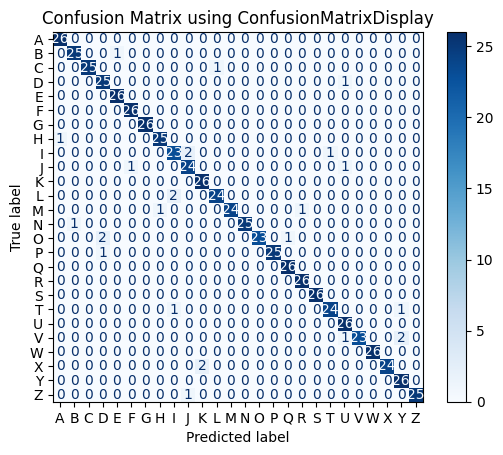

In [20]:
def teste_build_mlp():
    # Lendo os arquivos
    imagens = ler_arq_imagens('X.txt')
    classes = ler_arq_classes('Y_letra.txt')

    # Dividindo os dados em conjuntos de treinamento e teste
    x_train, y_train, x_test, y_test = dividir_dados(imagens, classes, test_proportion=0.5)

    # Inicializa MLP sem nenhum parâmetro 
    mlp = MultilayerPerceptron()

    # Chama a função para construir os pesos a partir do arquivo
    mlp.build_mlp('mlp.txt')

    # Testa a rede neural
    predictions = mlp.predict(x_test)

    acuracia, erro = mlp.get_accuracy(x_test, y_test)
    print(f"Acurácia do modelo: {acuracia}")
    print(f"Erro médio do modelo: {erro}")

    # Exibe algumas predições para verificação
    num_testes = 0
    acertos = 0
    for i in range(20):
        num_testes += 1

        predicao = vetor_para_letra(predictions[i])
        correto = vetor_para_letra(y_test[i])

        if predicao == correto:
            acertos += 1
        print(f"Predição: {predicao}, Real: {correto}")
    
    plotar_matriz_de_confusao(predictions, y_test)

teste_build_mlp()

Cross-validation

In [ ]:
def kfold(entrada, classes, num_particoes):
    """
    Divide os dados e classes em K partições para K-Fold Cross-Validation.

    Args:
        entrada (np.array): Vetor dos dados a serem divididos.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).

    Returns:
        dados_particionados (list): Lista de K partições dos dados.
        classes_particionadas (list): Lista de K partições das classes.
    """
    tam_entrada = entrada.shape[0]
    tam_particoes = int(tam_entrada / num_particoes)
    particoes = []

    # Embaralha os índices para os dados serem divididos de forma aleatória
    indices = np.arange(tam_entrada)
    np.random.shuffle(indices)

    # Divide o vetor de índice em K partes
    for i in range(num_particoes):
        if i != num_particoes - 1:
            particoes.append(indices[(i * tam_particoes) : ((i + 1) * tam_particoes)])
        else:
            particoes.append(indices[(i * tam_particoes) :])

    dados_particionados = []
    classes_particionadas = []

    # Define os vetores de dados e classificação de cada partição
    for p in particoes:
        dados_particionados.append(entrada[p])
        classes_particionadas.append(classes[p])

    return dados_particionados, classes_particionadas

In [ ]:
# Teste função K-Fold
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')

print(imagens.shape)
print(classes.shape)

imagens_part, classes_part = kfold(imagens, classes, 5)

for i in range(5):
    print(imagens_part[i].shape)
    print(classes_part[i].shape)


(1326, 120)
(1326, 26)
(265, 120)
(265, 26)
(265, 120)
(265, 26)
(265, 120)
(265, 26)
(265, 120)
(265, 26)
(266, 120)
(266, 26)


In [ ]:
def train_cross_validation(entrada, classes, num_particoes):
    """
    Realiza o treinamento com cross validation de uma MLP.

    Args:
        entrada (np.array): Vetor dos dados de entrada.
        classes (np.array): Vetor das classes dos dados.
        num_particoes (int): Número de partições (K).
    """
    particoes_dados, particoes_classes = kfold(entrada, classes, num_particoes)

    min_output_error = 0.01
    max_epochs_num = 300
    early_stop_param = 15
    learning_rate = 0.1

    acuracia_total = 0

    for i in range(num_particoes):
        print(f"Treinamento K-Fold {i + 1}: ")

        # Define conjunto de testes
        dados_teste = particoes_dados[i]
        classes_teste = particoes_classes[i]

        # Remove conjunto de testes das partições
        min_output_error, max_epochs_num, early_stop_param, learning_rate
        dados_treinamento = [particao for j, particao in enumerate(particoes_dados) if j != i]
        dados_treinamento = np.concatenate(dados_treinamento)
        classes_treinamento = [particao for j, particao in enumerate(particoes_classes) if j != i]
        classes_treinamento = np.concatenate(classes_treinamento)

        # Inicia MLP
        mlp = MultilayerPerceptron(min_output_error, max_epochs_num, early_stop_param, learning_rate)

        # Treina MLP
        mlp.train(dados_treinamento, classes_treinamento)

        print(f"Treinamento {i + 1} finalizado.")
        acuracia = mlp.get_accuracy(dados_teste, classes_teste)
        print(f"Acurácia: {acuracia:.2f}\n")

        acuracia_total += acuracia
    
    print("Cross-validation concluído.")
    print(f"Acurácia média: {acuracia_total / num_particoes:.2f}")

# Lendo os arquivos
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')

# Convertendo para float
classes = classes.astype(float)

train_cross_validation(imagens, classes, 5)

Treinamento K-Fold 1: 
Época 0/300, Acurácia: 0.06787330316742081, Erro de validação: 0.1503282946680903, Erro de treino: 0.2074031354575942
Época 10/300, Acurácia: 0.09502262443438914, Erro de validação: 0.1427572774062789, Erro de treino: 0.1422337745186372
Época 20/300, Acurácia: 0.5565610859728507, Erro de validação: 0.12972794325928058, Erro de treino: 0.12842902961446515
Época 30/300, Acurácia: 0.7013574660633484, Erro de validação: 0.11663740054126306, Erro de treino: 0.11287732914744321
Época 40/300, Acurácia: 0.8099547511312217, Erro de validação: 0.10659234912240378, Erro de treino: 0.09877656977632013
Época 50/300, Acurácia: 0.7918552036199095, Erro de validação: 0.10033463171428622, Erro de treino: 0.08753008503108323
Época 60/300, Acurácia: 0.8144796380090498, Erro de validação: 0.0957137401220487, Erro de treino: 0.08017770622659245


KeyboardInterrupt: 

## Exemplos de uso

In [ ]:
imagens = ler_arq_imagens('X.txt')
classes = ler_arq_classes('Y_letra.txt')
print(imagens.head())


In [ ]:
print(classes.head())

In [ ]:
# Executando o treinamento e teste da rede neural
mlp = MultilayerPerceptron()
mlp.main(imagens, classes)#

In [ ]:
# Plotando o erro de treinamento
plt.plot(mlp.training_errors)
plt.title('Erro de Treinamento por Época')
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid(True)
plt.show()


In [ ]:
# Criação de uma tabela com os erros de treinamento
df_erros_treinamento = pd.DataFrame({
    'Época': range(len(mlp.training_errors)),
    'Erro': mlp.training_errors
})

# Exibindo a tabela
print(df_erros_treinamento)


Falta:

- fazer o erro parar de diminuir pouco
- tirar sklearn do cross-validation
- verificar se o gráfico tá gerando certo
- gerar matriz de confusão para testes da rede


# Roteiro para vídeo

V1:
- Parte de treinamento do código (com e sem validação cruzada e parada antecipada) PARA: conjunto de dados CARACTERES COMPLETO (os outros de teste não entram)
- Estudo dos parâmetros (busca por valores adequados – grid) (?)
- Teste da MLP para o conjunto de dados CARACTERES COMPLETO

V2:
- 
